# Import needed libraries and read dataset

In [217]:
import numpy as np
import pandas as pd
from pandas import DatetimeIndex as dt
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
import pickle
%matplotlib inline
plt.style.use('bmh')

def compute_confidence_interval(scores):
    """
    Computing the 95% confidence interval 
    """
    mean_score = np.mean(scores)
    sem = stats.sem(scores)  # Standard error of the mean
    confidence_interval = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=sem)
    return confidence_interval


data = pd.read_csv('supermarket_sales.csv')
data

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


### Now perform basic data parsing to check for missing data, drop unecssary data and prepare for data transformation.

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64


array([[<Axes: title={'center': 'Unit price'}>,
        <Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Total'}>,
        <Axes: title={'center': 'cogs'}>],
       [<Axes: title={'center': 'gross margin percentage'}>,
        <Axes: title={'center': 'gross income'}>,
        <Axes: title={'center': 'Rating'}>, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

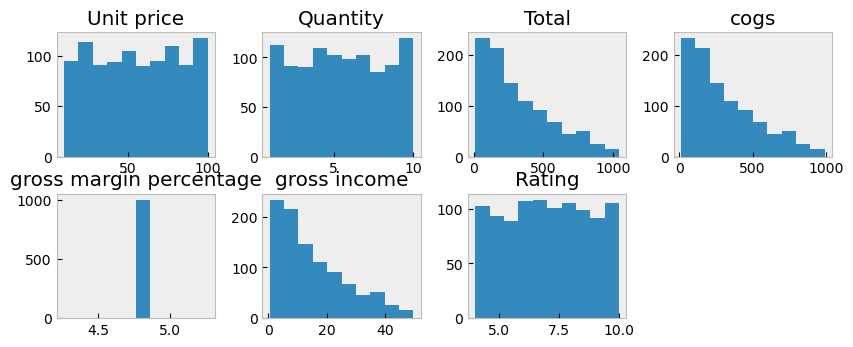

In [218]:
missing_data = data.isnull().sum()
print(missing_data)
data.hist(figsize=(10, 10), layout=(5, 4), grid=False)

### No missing data or visible outliers, now time to start preprocessing data

In [4]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=0)


train_target = data_train['gross income']
test_target = data_test['gross income']



data_train

NameError: name 'train_test_split' is not defined

## We will check for correlations between numerical values and target value 'gross income'
- In this case, for our visualization, row or column 4 holds the relations to our target value
- highly correlated features other than the target can pose as some potential model risks that are not 

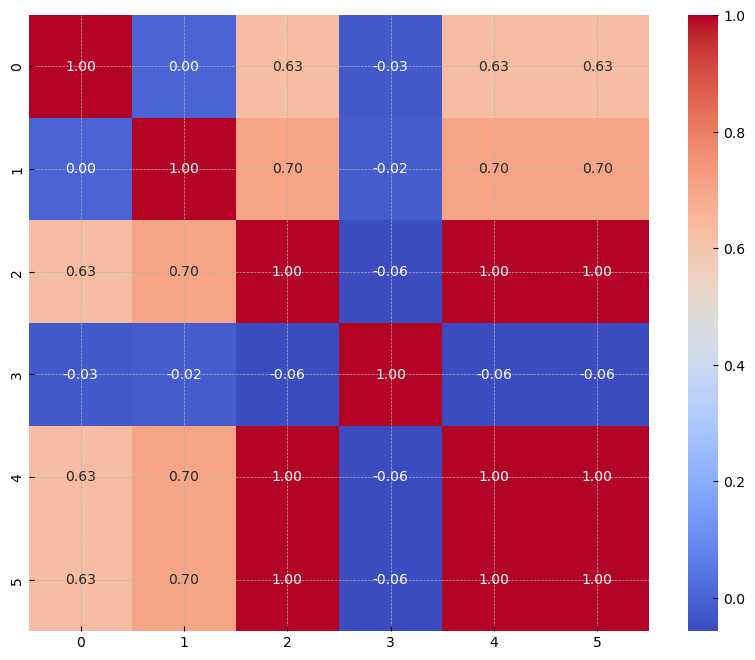

,0,1,2,3,4,5
0,1.000000,0.001034,0.628454,-0.025594,0.628454,0.628454
1,0.001034,1.000000,0.703549,-0.017327,0.703549,0.703549
2,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000
3,-0.025594,-0.017327,-0.057089,1.000000,-0.057089,-0.057089
4,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000
5,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000


In [220]:
data_numerical = pd.DataFrame(zip(data_train['Unit price'],
                                  data_train['Quantity'],
                                  data_train['Total'],
                                  data_train['Rating'],
                                  data_train['gross income'], 
                                  data_train['cogs']))

correlation_matrix = data_numerical.corr()
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()
correlation_matrix

## Now we must get rid of the target values to not interfere with preprocessing or training.

In [221]:
data_train1 = data_train.drop('gross income', axis = 1)
data_test1 = data_test.drop('gross income', axis =1)

## Looks like "Unit price" and "Quantity" are closely related. However, "Total" is extremely linearly related with 1.0, this needs to be investigated when training.

### Starting Encoders for Date and Time as Required
                                                                      

In [222]:
# Time Transformer
class Time_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):  # got rid of format thing
        pass
        
    def fit(self, X, y = None):
        return self  # we dont need to fit anything
    
    def transform(self, X):
        # ensuring X is a DataFrame and copying it
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        X_copy = X.copy()
        
        # performing time encoding
        # Time Encoding 
        # Integer Encoding for Time of the Day
        # 1. Morning (10:00 - 11:59), 2. Afternoon (12:00 - 16:59)
        # 3. Evening (17:00 - 18:59), 4. Night (19:00 - 20:59)
        # hour = pd.to_datetime(X_copy['Time']).dt.hour
        hour = pd.to_datetime(X['Time'], format='mixed').dt.strftime('%H').astype('float')
        hour_cat = pd.cut(hour, bins=[0, 12, 17, 19, 24], labels=[1, 2, 3, 4], right=False)
        
        # returning copy with encoded time
        X_copy['Time'] = hour_cat.astype(int)  # make it an integer
        return X_copy

# Date Transformer
class Date_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_copy = X.copy()
        X_copy['Date'] = pd.to_datetime(X_copy['Date']).dt.dayofweek
        return X_copy

## Now we can start to encode and scale data through pipelines for predicting gross income.
- Gross margin percentage is all the same value, it will not be useful and so it will be deleted. 
- We will also delete the Invoice ID for the same reason. Branch and City features seem to display the same information, we will delete the city name for simplicity. "COGS" is also too closely related to "Total", so it will also be deleted.
- All of this will be in our transformer to pipeline

In [223]:
# PREPROCESSOR & PIPELINE FORM 




preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', ['Invoice ID', 'City', 'gross margin percentage', 'cogs', 'Payment', 'Total']),
        ('date_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Date']),
        ('time_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Time']),
        ('branch_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Branch']),
        ('member_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Customer type']),
        ('gender_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Gender']),
        ('product_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Product line']),
        # adding numerical scaling
        ('num_scaler', StandardScaler(), ['Quantity', 'Unit price', 'Rating'])
    ],
    remainder='passthrough'  # keeps all other columns
)

## Here we are constructing our multiple linear regression pipeline using previous parts (no Regularizer)
- This model will not contain lasso regularization

In [224]:

pipeline = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor),
    # add my models
    ('regressor', LinearRegression())
    
])

## Training and Plotting Predictions without Regularizer

In [225]:
pipeline.fit(data_train1, train_target)

pipeline


Pipeline(steps=[('date_encode', Date_Encoder()),
                ('time_encode', Time_Encoder()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Invoice ID', 'City',
                                                   'gross margin percentage',
                                                   'cogs', 'Payment',
                                                   'Total']),
                                                 ('date_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Date']),
                                                 ('time_one_hot',
                                                  OneHotEncoder(handle_unknown='ign...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Branch']),
                                                 ('member_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Customer type']),
                                                 ('gender_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender']),
                                                 ('product_one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Product line']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['Quantity', 'Unit price',
                                                   'Rating'])])),
                ('regressor', LinearRegression())])

## We can now check our Cross Validation score to see its sensitivity to unseen data and calculate its 95% confidence interval.

In [226]:
cv_scores = cross_validate(pipeline, data_train1, train_target, cv=5, scoring=('r2', 'neg_mean_squared_error'))

# finding mean

r2_scores = cv_scores['test_r2']
mean_r2 = np.mean(r2_scores)

print (f"CV R^2 score mean: {mean_r2}")
print (f"CV NMSE scores: {cv_scores['test_neg_mean_squared_error']}")


std_r2 = np.std(r2_scores)

# we used 5 folds
n_folds = 5

# finding standard error of mean
sem_r2 = std_r2 / np.sqrt(n_folds)

# calculating 95% interval
confidence_interval_95 = scipy.stats.t.interval(0.95, n_folds - 1, loc=mean_r2, scale=sem_r2)

print(f"95% Confidence interval for R^2 mean score: {confidence_interval_95}")

CV R^2 score mean: 0.8838268021396655
CV NMSE scores: [-15.86684353 -16.92717764 -13.16940822 -15.78303808 -16.41242194]
95% Confidence interval for R^2 mean score: (0.8719809435421048, 0.8956726607372262)


### We have acheived 95% confidence interval for R^2 of  (87.198%, 89.567%)

## Now we will start out next model, but this time using the Lasso regularizer and using and Cross Validation scheme to find the best hyperparameters.
- First we will try some basic parameters for Lasso's alpha value which effects the lasso's strength 
- Then, we will construct a similar pipeline, but using the regularizer using Grid Search CV
- Lastly, we will construct another pipeline but using Random Search CV

## Constructing second model with lasso using grid search CV & random search CV plotting results
- For this model, we will make predictions using the same previous preprocessor and also another prediction using only categorical features.

In [227]:

alphas = [0.0001, 0.05, 0.01, 0.2, 0.1, 0.15, 0.16, 0.17, 0.2, 0.3, 0.4, 0.5]

parameters = {'alpha': alphas}


pipeline_grid = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor),
    # add my models
    ('Lasso_Grid', GridSearchCV(estimator = Lasso(random_state = 0), param_grid = parameters, cv = 5, scoring = 'r2'))])


param_dist = {'alpha': stats.expon(scale = 0.005)}

pipeline_random = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor),
    # add my models
    ('Lasso_Random', RandomizedSearchCV(estimator = Lasso(random_state = 0), param_distributions = param_dist, cv = 5, scoring = 'r2'))])

#Training
pipeline_grid.fit(data_train1, train_target)
pipeline_random.fit(data_train1, train_target)


final_model1 = pipeline_grid
# pickle file
with open ('final_model1.pkl', 'wb') as file:
    pickle.dump(final_model1, file)



## Testing Lassos

Best found hyperparameters for Grid Search: {'alpha': 0.15}
 Highest R^2 score for Grid Search: 0.8870963838646044
Best found hyperparameters for Random Search: {'alpha': 0.01805733710374144}
 Highest R^2 score for Random Search: 0.8849323150857729
95% CI for R^2 of Grid Search): (0.8934297114240409, 0.8934346250290494)
95% CI for R^2 of Random Search: (0.8898126951377474, 0.8898174949241537)


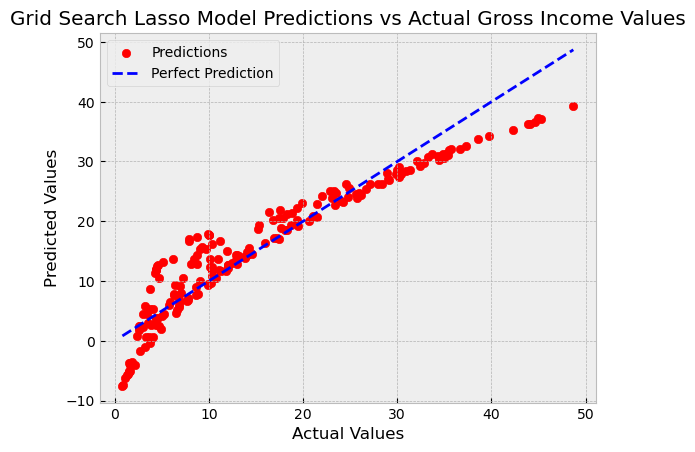

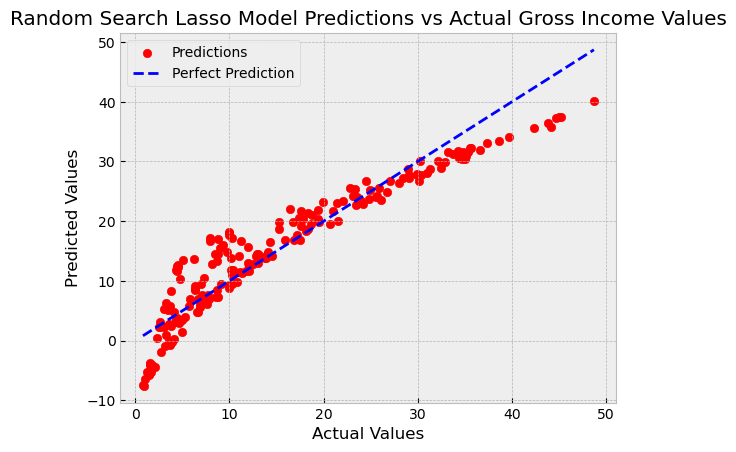

In [228]:

# Printing scores
print(f"Best found hyperparameters for Grid Search: {pipeline_grid['Lasso_Grid'].best_params_}")
print(f" Highest R^2 score for Grid Search: {pipeline_grid['Lasso_Grid'].best_score_}")

print(f"Best found hyperparameters for Random Search: {pipeline_random['Lasso_Random'].best_params_}")
print(f" Highest R^2 score for Random Search: {pipeline_random['Lasso_Random'].best_score_}")


prediction_grid = pipeline_grid.predict(data_test1)
prediction_rand = pipeline_random.predict(data_test1)

# 95% CONFIDENCE INTERVAL
r2_score_grid = r2_score(test_target, prediction_grid)
r2_score_rand = r2_score(test_target, prediction_rand)

scores_grid = [r2_score(test_target, prediction_grid + np.random.normal(0, 0.01, len(test_target))) for _ in range(1000)]
scores_rand = [r2_score(test_target, prediction_rand + np.random.normal(0, 0.01, len(test_target))) for _ in range(1000)]


ci_grid = compute_confidence_interval(scores_grid)
ci_rand= compute_confidence_interval(scores_rand)

print(f"95% CI for R^2 of Grid Search): {ci_grid}")
print(f"95% CI for R^2 of Random Search: {ci_rand}")



#plotting GridCV
plt.scatter(test_target, prediction_grid, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Grid Search Lasso Model Predictions vs Actual Gross Income Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#plostting RandCV
plt.scatter(test_target, prediction_rand, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Random Search Lasso Model Predictions vs Actual Gross Income Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Grid search appears to have a slightly better interval.

## Training & testing model using only categorical data.

Best found hyperparameters for dropped: {'alpha': 0.17}
 Highest R^2 score for dropped: -0.008692884893453568
95% CI for R^2 (model with dropped features): (-0.02050285457346388, -0.020488265861529215)


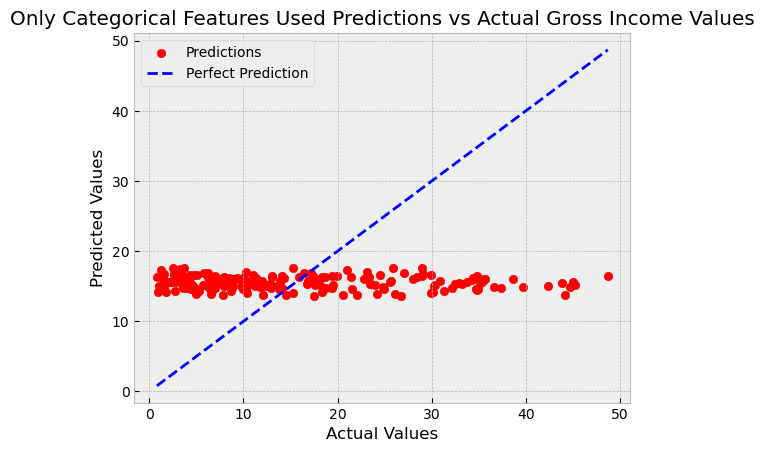

In [229]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', ['Invoice ID', 'City', 'gross margin percentage', 'cogs', 'Payment',
                          'Total', 'Gender', 'Product line', 'Date', 'Time',
                          'Customer type', 'Quantity', 'Unit price']),
        ('branch_one_hot', OneHotEncoder(), ['Branch']),
        ('member_one_hot', OneHotEncoder(), ['Customer type']),
        ('gender_one_hot', OneHotEncoder(), ['Gender']),
        ('product_one_hot', OneHotEncoder(), ['Product line'])
       
       
    ],
    remainder='passthrough'  # keeps all other columns
)

pipeline_dropped = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor2),
    # add my models
    ('Lasso_Grid', GridSearchCV(estimator = Lasso(random_state = 0, max_iter = 5000), param_grid = parameters, cv = 5, scoring = 'r2'))])

pipeline_dropped.fit(data_train1, train_target)

prediction_dropped = pipeline_dropped.predict(data_test1)

r2_score_dropped = r2_score(test_target, prediction_dropped)

scores_dropped = [r2_score(test_target, prediction_dropped + 
                           np.random.normal(0, 0.01, len(test_target))) for _ in range(1000)]

ci_dropped = compute_confidence_interval(scores_dropped)

print(f"Best found hyperparameters for dropped: {pipeline_dropped['Lasso_Grid'].best_params_}")
print(f" Highest R^2 score for dropped: {pipeline_dropped['Lasso_Grid'].best_score_}")


print(f"95% CI for R^2 (model with dropped features): {ci_dropped}")


# plotting dropped
plt.scatter(test_target, prediction_dropped, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Only Categorical Features Used Predictions vs Actual Gross Income Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### Model with only categorical features fails to make valid predicitons.

## Predicting Unit Price 

### Starting with checking correlation matrix of numerical values

In [230]:
correlation_matrix  ### 0: Unit price, 1: Quantity, 2: Total, 3: Rating, 4: gross income, 5: cogs

,0,1,2,3,4,5
0,1.000000,0.001034,0.628454,-0.025594,0.628454,0.628454
1,0.001034,1.000000,0.703549,-0.017327,0.703549,0.703549
2,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000
3,-0.025594,-0.017327,-0.057089,1.000000,-0.057089,-0.057089
4,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000
5,0.628454,0.703549,1.000000,-0.057089,1.000000,1.000000


### Unit Price is most correlated to Total, gross income, and cogs. But as we know, each of these categories relay the same information due to their 1.0 correlation score. Due to this, we only include one of these features for our model. We will also not be including rating due to its low correlation score.
- After trying different numerical feature combinations, it appears that uaing Total and Quantity provide better predictions even though Quantity had a low correlation score.

### Making train/test sets and constructing pipeline

In [231]:
# making sets
data_train2 = data_train.drop('Unit price', axis =1)
data_test2 = data_test.drop('Unit price', axis =1)

train_target2 = data_train['Unit price']
test_target2 = data_test['Unit price']

In [232]:
preprocessor3 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', ['Invoice ID', 'City', 'gross margin percentage', 'cogs', 'Payment', 'Rating']),
        ('date_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Date']),
        ('time_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Time']),
        ('branch_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Branch']),
        ('member_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Customer type']),
        ('gender_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Gender']),
        ('product_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Product line']),
        # adding numerical scaling
        ('num_scaler', StandardScaler(), ['Total','Quantity'])
    ],
    remainder='passthrough'  # keeps all other columns
)


up_pipeline = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor3),
    # add my models
    ('regressor', LinearRegression())
    
])

### Training and checking scores / testing

CV R^2 score mean: 0.7703474633622037
CV NMSE scores: [-134.42592169 -179.15262799 -154.52109328 -161.94780941 -160.72322565]
95% Confidence interval for R^2 mean score: (0.8564013165416742, 0.9112522877376568)


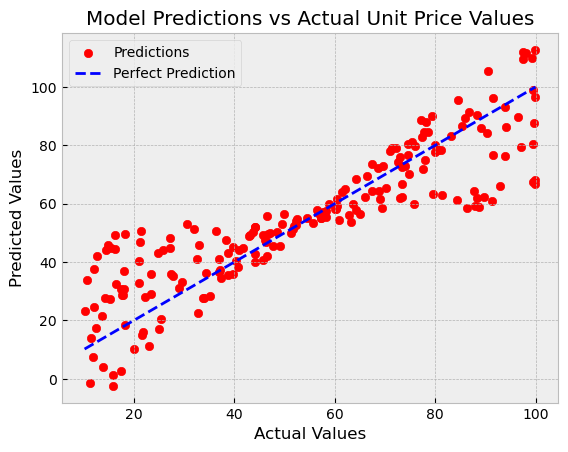

In [233]:
#training
up_pipeline.fit(data_train2, train_target2)


# predict
up_prediction = up_pipeline.predict(data_test2)







# 95% confidence interval
cv_scores2 = cross_validate(up_pipeline, data_train2, train_target2, cv=5, scoring=('r2', 'neg_mean_squared_error'))

# finding mean
r2_scores2 = cv_scores2['test_r2']
up_mean_r2 = np.mean(r2_scores2)

print (f"CV R^2 score mean: {up_mean_r2}")
print (f"CV NMSE scores: {cv_scores2['test_neg_mean_squared_error']}")

std_r2 = np.std(r2_scores2)

# we used 5 folds
n_folds = 5

# finding standard error of mean
sem_r2 = std_r2 / np.sqrt(n_folds)

# calculating 95% interval
up_confidence_interval_95 = scipy.stats.t.interval(0.95, n_folds - 1, loc=mean_r2, scale=sem_r2)
print(f"95% Confidence interval for R^2 mean score: {up_confidence_interval_95}")







# make the plot
plt.scatter(test_target2, up_prediction, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target2), max(test_target2)], [min(test_target2), max(test_target2)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Model Predictions vs Actual Unit Price Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Looks like our model has an average  R^2 score of 77.03% with a 95% confidence interval of (85.64%, 91.12%)

## Start construction and training of Lasso models using Grid and Random search

In [234]:

alphas = [ 0.09, 0.1, 0.3, 0.5, 0.8]

parameters = {'alpha': alphas}


up_pipeline_grid = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor3),
    # add my models
    ('Lasso_Grid', GridSearchCV(estimator = Lasso(random_state = 0), param_grid = parameters, cv = 5, scoring = 'r2'))])


param_dist = {'alpha': stats.expon(scale = 0.3)}

up_pipeline_random = Pipeline([
    # first handle date & time
    ('date_encode', Date_Encoder()),
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor3),
    # add my models
    ('Lasso_Random', RandomizedSearchCV(estimator = Lasso(random_state = 0), param_distributions = param_dist, cv = 5, scoring = 'r2'))])

#Training
up_pipeline_grid.fit(data_train2, train_target2)
up_pipeline_random.fit(data_train2, train_target2)



final_model2 = up_pipeline_random
# pickle file
with open ('final_model2.pkl', 'wb') as file:
    pickle.dump(final_model2, file)


C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.802e+03, tolerance: 4.440e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.121e+03, tolerance: 4.440e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.278e+03, toleranc

## Testing the two models

In [235]:

# predict
prediction1 = up_pipeline_grid.predict(data_test2)
prediction2 = up_pipeline_random.predict(data_test2)








In [236]:
# Cross Val

# 95% confidence interval
cv_scores = cross_validate(up_pipeline_grid, data_train2, train_target2, cv=5, scoring=('r2', 'neg_mean_squared_error'))
cv_scores2 = cross_validate(up_pipeline_random, data_train2, train_target2, cv=5, scoring=('r2', 'neg_mean_squared_error'))


C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.180e+03, tolerance: 3.502e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.642e+03, tolerance: 3.453e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e+03, toleranc

Grid CV R^2 score mean: 0.7772174114437322
Grid CV NMSE scores: [-130.75171705 -169.40068859 -147.05751005 -159.44590412 -161.03808672]
Random CV R^2 score mean: 0.7771832185895879
Random CV NMSE scores: [-130.90570649 -169.49402685 -147.41902991 -158.95876899 -160.96082226]
95% Confidence interval for R^2 mean score: (0.8605382777492169, 0.9071153265301141)
95% Confidence interval for R^2 mean score: (0.8605382777492169, 0.9071153265301141)


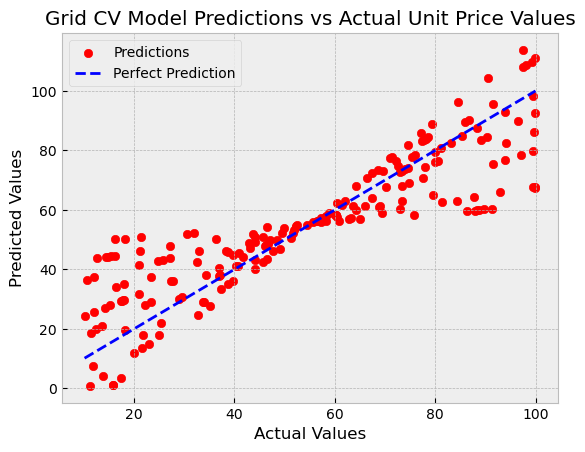

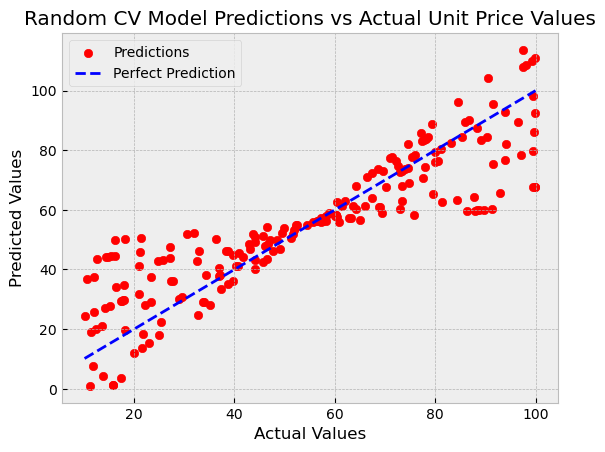

In [237]:


# finding mean
r2_scores = cv_scores['test_r2']
up_mean_r = np.mean(r2_scores)
r2_scores2 = cv_scores2['test_r2']
up_mean_r2 = np.mean(r2_scores2)

print (f"Grid CV R^2 score mean: {up_mean_r}")
print (f"Grid CV NMSE scores: {cv_scores['test_neg_mean_squared_error']}")
print (f"Random CV R^2 score mean: {up_mean_r2}")
print (f"Random CV NMSE scores: {cv_scores2['test_neg_mean_squared_error']}")

std_r = np.std(r2_scores)
std_r2 = np.std(r2_scores2)


# we used 5 folds
n_folds = 5

# finding standard error of mean
sem_r2 = std_r / np.sqrt(n_folds)
sem_r2_2 = std_r2 / np.sqrt(n_folds)
# calculating 95% interval
up_confidence_interval_95 = scipy.stats.t.interval(0.95, n_folds - 1, loc=mean_r2, scale=sem_r2)
print(f"95% Confidence interval for R^2 mean score: {up_confidence_interval_95}")
up_confidence_interval_95_2 = scipy.stats.t.interval(0.95, n_folds - 1, loc=mean_r2, scale=sem_r2)
print(f"95% Confidence interval for R^2 mean score: {up_confidence_interval_95_2}")







# make the plot for grid
plt.scatter(test_target2, prediction1, color='red', label='Predictions')


# perfect prediction
plt.plot([min(test_target2), max(test_target2)], [min(test_target2), max(test_target2)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Grid CV Model Predictions vs Actual Unit Price Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# make plot for rand
plt.scatter(test_target2, prediction2, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target2), max(test_target2)], [min(test_target2), max(test_target2)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Random CV Model Predictions vs Actual Unit Price Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### Random search cv has a slightly higher R^2 value

## Predicting day of the week of purchase

In [241]:
# use accuracy
# preprocess, make pipeline, 

# classifier
log_reg = LogisticRegression (penalty = None, random_state = 0, max_iter  = 300)

# making training data
data_train3 = data_train.drop('Date', axis = 1)
encode = Date_Encoder()
target_train3 = encode.transform(data_train['Date'])
target_train3 = target_train3.values.ravel()

# making testing data
data_test3 = data_test.drop('Date', axis = 1)
target_test3 = encode.transform(data_test['Date'])



preprocessor4 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', ['Invoice ID', 'City', 'gross margin percentage', 'cogs', 'Payment', 'Total']),
        ('time_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Time']),
        ('branch_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Branch']),
        ('member_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Customer type']),
        ('gender_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Gender']),
        ('product_one_hot', OneHotEncoder(handle_unknown='ignore'), ['Product line']),
        # adding numerical scaling
        ('num_scaler', StandardScaler(), ['Quantity', 'Unit price', 'Rating']),
       
    ],
    remainder='passthrough'  # keeps all other columns
)


first_pipe = Pipeline([
    # first handle date & time
    ('time_encode', Time_Encoder()),
    # use preprocessor
    ('preprocessor', preprocessor4),
    # add my models
    ('log_reg', log_reg)
    
])


#training
first_pipe.fit(data_train3, target_train3)


final_model3 = first_pipe
# pickle file
with open ('final_model3.pkl', 'wb') as file:
    pickle.dump(final_model3, file)
